# Evaluate the Harmony question matcher using the existing McElroy et al harmonisation tool as a gold standard

This is a validation of Harmony against the questionnaire harmonisation tool developed by McElroy et al in 2020.

You can read in detail about the validation report here:

https://harmonydata.org/measuring-the-performance-of-nlp-algorithms/

You can read an explanation of the technologies evaluated here:

https://harmonydata.org/how-does-harmony-work/

In [1]:
MODEL_NAME = "Model 8: Transformer with cosine similarity and preprocessing for opposite senses\nparaphrase-multilingual-MiniLM-L12-v2"

import sys
sys.path.append("../front_end")
from utils.question_matcher_transformer_huggingface_negation_efficient import QuestionMatcherTransformerHuggingFaceNegationEfficient
qm = QuestionMatcherTransformerHuggingFaceNegationEfficient('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
match_function = lambda question_dfs : qm.match_questions(question_dfs, is_use_cosine_similarity=True)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/harmony/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from load_validation_data import validation_data
from validation import validate

<Figure size 800x800 with 0 Axes>

Validating on dataset McElroy et al Childhood
	Processing 47 instruments of average length 23 questions each


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/harmony/lib/python3.10/site-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  a = torch.tensor(a)


	Calculated 562315 match scores
	Generated 40708 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES McElroy et al Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Doesnt Share Toys,"Is helpful if someone is hurt, upset or feeling ill",0.00,1
1,Child likes to sit and watch TV rather than play active games,averageworks moderately well,0.01,1
2,Child likes to sit and watch TV rather than play active games,"""A very hard worker",0.02,1
3,Other Children Dislike Child,Takes usual amount of time to make friends,0.02,1
4,Tries to be Fair in Games,Child likes a cuddle,0.02,1
5,Does things on Own,She is very friendly with strangers,0.03,1
6,Tries to be Fair in Games,Child smiles when child sees their parent(s),0.04,1
7,Fails to finish things he,sometimes daydreams in class,0.04,1
8,Stares into Space,"""Normally energetic",0.05,1
9,Helps Round House Voluntary,Is considerate of other people's feelings,0.06,1



FALSE POSITIVES OR WEAKEST REJECTIONS McElroy et al Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Bullies Other Children,Is bullied by other children,0.93,0
1,Child bullies other children,Is bullied by other children,0.93,0
2,"usually gloomy and sad"" or ""Normal attitude to criticism and punishment","frequently disobedient"" or ""Normal attitude to criticism and punishment",0.86,0
3,Bullies Other Children,Is picked on or bullied by other children,0.85,0
4,Is picked on or bullied by other children,Child bullies other children,0.85,0
5,Often fights with other children or bullies them,Is bullied by other children,0.84,0
6,She reacts intensely when upset,She gest upset easily,0.83,0
7,"Has many worries, often seems worried","Has many fears, is easily scared",0.83,0
8,She reacts intensely when upset,She tends to be somewhat emotional,0.82,0
9,Child is squirmy or fidgety,Child is fussy or overparticular,0.81,0


Validating on dataset McElroy et al Adulthood
	Processing 28 instruments of average length 16 questions each
	Calculated 95600 match scores
	Generated 9468 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES McElroy et al Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,I felt I was no good anymore,Are you selfconscious in public (rate simple ideas of reference),0.00,1
1,I thought nobody really loved me,Are you selfconscious in public (rate simple ideas of reference),0.06,1
2,I did everything wrong,Are you selfconscious in public (rate simple ideas of reference),0.07,1
3,I hated myself,Are you selfconscious in public (rate simple ideas of reference),0.09,1
4,muscles feel tensed up (rate muscular tension),Found everything getting on top of you,0.10,1
5,I thought nobody really loved me,Been satisfied with the way you've carried out your task,0.12,1
6,I cried a lot,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.12,1
7,I didnt enjoy anything at all,let your appearance go (rate loss of interest),0.13,1
8,I laughed a lot,have you felt particularly low or depressed first thing in the mornings,0.13,1
9,I laughed a lot,Do you often feel depressed,0.14,1



FALSE POSITIVES OR WEAKEST REJECTIONS McElroy et al Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,"been feeling reasonably happy, all things considered",Been feeling perfectly well and in good health,0.81,0
1,Have you been a very nervous person,Have you ever had a nervous breakdown,0.79,0
2,Are you frightened of going out alone or of meeting people,Are you scared to be alone when there are not friends near you,0.79,0
3,Do you suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.79,0
4,Have you been a very nervous person,"have you been in situations such as in a crowd or an enclosed space or meeting people, when you became unduly anxious",0.79,0
5,Have you ever had a nervous breakdown,Have you had times when you felt shaky or you heart pounded or you felt sweaty and you simply had to do something about it (rate panic attacks),0.77,0
6,Do you often suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.77,0
7,Have you felt so down in the dumps that nothing could cheer you up,"During the last days, about how often did you feel so depressed nothing could cheer you up",0.76,0
8,Do you often get worried about things,Do you often suddenly become scared for no good reason,0.76,0
9,Been feeling nervous and strungup all the time,Been getting scared or panicky for no good reason,0.75,0


Validating on dataset GAD-7 (EN/PT)
Found Portuguese dataset GAD-7 (EN/PT)
Found Portuguese dataset GAD-7 (EN/PT)
	Processing 2 instruments of average length 7 questions each
	Calculated 49 match scores
	Generated 49 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES GAD-7 (EN/PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Being so restless that it is hard to sit still,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.79,1
1,Not being able to stop or control worrying,Não ser capaz de impedir ou de controlar as preocupações,0.85,1
2,Becoming easily annoyed or irritable,Ficar facilmente aborrecido/a ou irritado/a,0.85,1
3,Trouble relaxing,Dificuldade para relaxar,0.86,1
4,Worrying too much about different things,Preocupar-se muito com diversas coisas,0.86,1
5,"Feeling nervous, anxious, or on edge","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.91,1
6,"Feeling afraid, as if something awful might happen",Sentir medo como se algo horrível fosse acontecer,0.93,1



FALSE POSITIVES OR WEAKEST REJECTIONS GAD-7 (EN/PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Worrying too much about different things,Não ser capaz de impedir ou de controlar as preocupações,0.68,0
1,Trouble relaxing,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.64,0
2,Not being able to stop or control worrying,Preocupar-se muito com diversas coisas,0.63,0
3,Becoming easily annoyed or irritable,"Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.62,0
4,"Feeling afraid, as if something awful might happen","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.61,0
5,Becoming easily annoyed or irritable,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.61,0
6,"Feeling afraid, as if something awful might happen",Preocupar-se muito com diversas coisas,0.60,0
7,"Feeling nervous, anxious, or on edge",Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.60,0
8,Being so restless that it is hard to sit still,Dificuldade para relaxar,0.59,0
9,"Feeling nervous, anxious, or on edge",Sentir medo como se algo horrível fosse acontecer,0.58,0


Validating on dataset BHRCS SDQ/CBCL (PT)
Found Portuguese dataset BHRCS SDQ/CBCL (PT)
Found Portuguese dataset BHRCS SDQ/CBCL (PT)
	Processing 2 instruments of average length 73 questions each
	Calculated 3025 match scores
	Generated 3025 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES BHRCS SDQ/CBCL (PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,É barulhento(a) demais,Pensa nas coisas antes de fazê-las,0.16,1
1,É alvo de muitas gozações,Outras crianças pegam no pé ou a atormentam,0.27,1
2,Fica emburrado(a) facilmente,Frequentemente tem acessos de raiva ou crises de birra,0.27,1
3,Acha que tem que fazer tudo perfeito,"Fica inseguro quando tem que fazer alguma coisa pela primeira vez, facilmente perde a confiança em si mesmo",0.29,1
4,Fala demais,Pensa nas coisas antes de fazê-las,0.30,1
5,Não vai bem na escola,"Completa as tarefas que começa, tem boa concentração",0.32,1
6,Tem medo da escola,"Tem muitos medos, assusta-se facilmente",0.34,1
7,Não se dá bem com outras crianças,Tem pelo menos um bom amigo ou uma boa amiga,0.36,1
8,É muito acanhado(a) ou tímido(a),"Fica inseguro quando tem que fazer alguma coisa pela primeira vez, facilmente perde a confiança em si mesmo",0.41,1
9,"Desrespeita as regras em casa, na escola ou em outros lugares",Geralmente é obediente e faz normalmente o que os adultos lhe pedem,0.43,1



FALSE POSITIVES OR WEAKEST REJECTIONS BHRCS SDQ/CBCL (PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Não se dá bem com outras crianças,É gentil com crianças mais novas,0.88,0
1,As outras crianças não gostam dele(a),É gentil com crianças mais novas,0.76,0
2,Não se dá bem com outras crianças,Outras crianças pegam no pé ou a atormentam,0.71,0
3,"Náuseas, enjoos","Muitas vezes se queixa de dor de cabeça, dor de barriga ou enjoo",0.71,0
4,"Fica sem jeito na frente das pessoas com facilidade, preocupado(a) com que os outros vão pensar dele (a)","Tem muitas preocupações, muitas vezes parece preocupado com tudo",0.70,0
5,Tem mudanças repentinas de humor ou de sentimentos,"Frequentemente parece triste, desanimado ou choroso",0.70,0
6,Fica confuso(a) ou desorientado(a),Frequentemente engana ou mente,0.70,0
7,É impulsivo(a) ou age sem pensar,Frequentemente engana ou mente,0.69,0
8,"Isola-se, não se relaciona com os outros",Tem consideração pelos sentimentos de outras pessoas,0.69,0
9,Prefere estar com crianças mais novos,É gentil com crianças mais novas,0.68,0


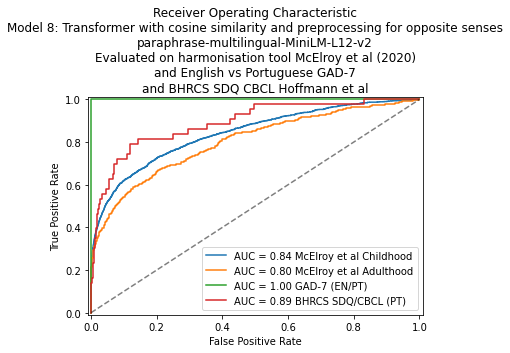

In [3]:
validate(validation_data, match_function, MODEL_NAME)